In [1]:
!pip3 install bertviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 157 kB 19.7 MB/s 
     |████████████████████████████████| 5.5 MB 47.8 MB/s 
     |████████████████████████████████| 1.3 MB 64.7 MB/s 
     |████████████████████████████████| 132 kB 78.6 MB/s 
     |████████████████████████████████| 182 kB 76.8 MB/s 
     |████████████████████████████████| 7.6 MB 63.3 MB/s 
     |████████████████████████████████| 10.2 MB 66.9 MB/s 
     |████████████████████████████████| 79 kB 9.8 MB/s 
     |████████████████████████████████| 140 kB 78.7 MB/s 
     |████████████████████████████████| 127 kB 83.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
tf.test.is_built_with_cuda()
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import pyarrow.parquet as pq

from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from bertviz import head_view, model_view, neuron_view
import random
# Set the seed value all over the place to make this reproducible.
seed_val = 42


random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)



In [3]:
class ExobootDataset(Dataset):
    """Windowed Gait dataset."""

    def __init__(self, gait_data, window_size=50, meas_scale=None, speed_scale=None, incline_scale=None, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            window_size (integer): size of the window to apply to the data
            speed_scale (tuple, optional): A 2-tuple of the lower and upper bounds to scale the speed
            incline_scale (tuple, optional): A 2-tuple of the lower and upper bounds to scale the incline
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.gait_data = gait_data
        self.window_size = window_size
        self.meas_scale = meas_scale
        self.speed_scale = speed_scale
        self.incline_scale = incline_scale
        self.transform = transform

    def __len__(self):
        return len(self.gait_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if idx < self.window_size and idx >= 0:
          # idx = len(self.gait_data)-1
          idx = random.randint(self.window_size, len(self.gait_data)-1)
          # print('saturating')


        meas_idxs = [0,1,2,3,4,5,6]

        #phase, speed, incline, is_stairs, is_moving
        gait_state_idxs = [7,8,9,10,11]  
        measurements = self.gait_data.iloc[idx-self.window_size:idx,meas_idxs].to_numpy()
        
        gait_states = self.gait_data.iloc[idx,gait_state_idxs].to_numpy()

        # sample = {'meas': measurements, 'state': gait_states}
        
        if self.meas_scale is not None:
            for i in range(len(meas_idxs)):
                lb = self.meas_scale[i,0]
                ub = self.meas_scale[i,1]
                measurements[:,i] = ((1 - 0)/(ub - lb)) * (measurements[:,i] - lb)

        if self.speed_scale:
            lb = self.speed_scale[0]
            ub = self.speed_scale[1]
            gait_states[1] = ((1 - 0)/(ub - lb)) * (gait_states[1] - lb)

        if self.incline_scale:
            lb = self.incline_scale[0]
            ub = self.incline_scale[1]
            gait_states[2] = ((1 - 0)/(ub - lb)) * (gait_states[2] - lb)

        
        phase_as_angle = 2*np.pi*(gait_states[0]-0.5)
        cp = np.cos(phase_as_angle)
        sp = np.sin(phase_as_angle)
        gait_states_new = np.zeros(gait_states.shape[0]+1,)
        gait_states_new[0] = cp
        gait_states_new[1] = sp
        gait_states_new[2:] = gait_states[1:]
        gait_states = gait_states_new

        sample = {'meas': measurements, 'state': gait_states}

        if self.transform:
            sample = self.transform(sample, self.window_size)
        
        return sample
        
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample, window_size):
        meas, state = sample['meas'], sample['state']
       
        meas = torch.from_numpy(meas).float()
        state = torch.from_numpy(state).float()
        state = torch.unsqueeze(state, dim=0)

        return {'meas': meas, 
                'state': state}



In [4]:
#RUN THIS TO SET UP COLAB
ON_COLAB = True
if ON_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    drive_path = '/content/drive/MyDrive/Phase ML Data/'

Mounted at /content/drive


In [5]:
window_size = 100
meas_scale = np.array([[-69.35951035,  27.62815047],\
                            [-456.18013759,  401.13782617],\
                            [-63.71649984,  22.06632622],\
                            [-213.4786175,   396.93801619],\
                            [-35.26603985,  20.78473636],\
                            [-20.95456523,  14.63961137],\
                              [0,1]])
speed_scale = (0,2)
incline_scale = (-10,10)


data_filename = 'exoboot_AB04_data.csv'
# data_filename = 'exoboot_AB05_data.csv'

if ON_COLAB:
  exoboot_data = pd.read_csv(drive_path+data_filename)
else:
  exoboot_data = pd.read_csv(data_filename)




dataset = ExobootDataset(gait_data=exoboot_data,
                                  meas_scale=meas_scale,
                                  window_size = window_size,
                                  speed_scale = speed_scale,
                                  incline_scale = incline_scale,
                                  transform=ToTensor())

print(exoboot_data.head() )

   foot_angles  foot_vel_angles  shank_angles  shank_vel_angles  \
0    -6.057912       -42.911006    -11.342663        -98.441231   
1    -6.473913       -41.676238    -12.316831       -105.819280   
2    -6.859717       -44.050802    -13.366502       -107.679036   
3    -7.277526       -50.876873    -14.432763       -106.977816   
4    -7.733547       -56.214143    -15.503496       -101.063182   

   heel_acc_forward  heel_acc_up      dt  phase_ground_truth  \
0          0.893712     3.580848  0.0100            0.000000   
1          0.590130     3.755495  0.0100            0.015500   
2          1.180324     5.018044  0.0100            0.032167   
3          2.026375     6.586451  0.0100            0.048833   
4          2.871570     7.914490  0.0101            0.065667   

   speed_ground_truth  incline_ground_truth  is_stairs  is_moving  
0            2.263252                   0.0        0.0        1.0  
1            2.263252                   0.0        0.0        1.0  
2       

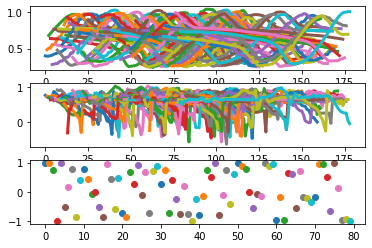

In [ ]:
fig, axs = plt.subplots(3,1)

for i in range(0,80):
  y = train_dataset[i+window_size]['meas'][:,0]
  y1 = train_dataset[i+window_size]['meas'][:,4]
  x = np.array([j for j in range(len(y))])
  x = x + i

  yy = train_dataset[i+window_size]['state'][:,0]
  axs[0].plot(x,y,linewidth=3)
  axs[1].plot(x,y1,linewidth=3)
  axs[2].plot(i,yy,'o',linewidth=3)



In [28]:
class PositionalEncoder(nn.Module):
    """
    The authors of the original transformer paper describe very succinctly what 
    the positional encoding layer does and why it is needed:
    
    "Since our model contains no recurrence and no convolution, in order for the 
    model to make use of the order of the sequence, we must inject some 
    information about the relative or absolute position of the tokens in the 
    sequence." (Vaswani et al, 2017)
    Adapted from: 
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(
        self, 
        dropout: float=0.1, 
        max_seq_len: int=100, 
        d_model: int=512,
        batch_first: bool=True,
        ):

        """
        Parameters:
            dropout: the dropout rate
            max_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model 
                     (Vaswani et al, 2017)
        """

        super().__init__()

        self.d_model = d_model
        
        self.dropout = nn.Dropout(p=dropout)

        self.batch_first = batch_first
        self.max_seq_len = max_seq_len
        self.x_dim = 1 if batch_first else 0
        pe = torch.zeros((1,max_seq_len,d_model))
        self.register_buffer('pe', pe, persistent=False)

        
    def forward(self, x: Tensor, dts: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val] or 
               [enc_seq_len, batch_size, dim_val]
        """
        
        #dts should be (batch_size, 50, 1)
        #print('2')
        #print(dts.shape)
  
        t_rel = torch.cumsum(torch.flip(dts, [1]), dim=1)

        #flip order so most recent integrated is last
        t_rel = torch.flip(t_rel, [1])
        
        #repeat integrated time across the embedding dimension
        t_rel = t_rel.repeat(1, 1, self.d_model)

        self.pe[0,:-1,:] = t_rel[0,1:,:]
        
        # self.pe = self.pe.to(device)
        x = x + self.pe

        return self.dropout(x)

class GaitTransformer(nn.Module):

    """
    This class implements a transformer model that can be used for times series
    forecasting. This time series transformer model is based on the paper by
    Wu et al (2020) [1]. The paper will be referred to as "the paper".
    A detailed description of the code can be found in my article here:
    https://towardsdatascience.com/how-to-make-a-pytorch-transformer-for-time-series-forecasting-69e073d4061e
    In cases where the paper does not specify what value was used for a specific
    configuration/hyperparameter, this class uses the values from Vaswani et al
    (2017) [2] or from PyTorch source code.
    Unlike the paper, this class assumes that input layers, positional encoding 
    layers and linear mapping layers are separate from the encoder and decoder, 
    i.e. the encoder and decoder only do what is depicted as their sub-layers 
    in the paper. For practical purposes, this assumption does not make a 
    difference - it merely means that the linear and positional encoding layers
    are implemented inside the present class and not inside the 
    Encoder() and Decoder() classes.
    [1] Wu, N., Green, B., Ben, X., O'banion, S. (2020). 
    'Deep Transformer Models for Time Series Forecasting: 
    The Influenza Prevalence Case'. 
    arXiv:2001.08317 [cs, stat] [Preprint]. 
    Available at: http://arxiv.org/abs/2001.08317 (Accessed: 9 March 2022).
    [2] Vaswani, A. et al. (2017) 
    'Attention Is All You Need'.
    arXiv:1706.03762 [cs] [Preprint]. 
    Available at: http://arxiv.org/abs/1706.03762 (Accessed: 9 March 2022).
    """

    def __init__(self, 
        input_size: int,
        num_predicted_features: int=4,
        batch_first: bool=True,
        dim_val: int=512,  
        n_encoder_layers: int=4,
        n_decoder_layers: int=4,
        n_heads: int=8,
        enc_seq_len: int=50,
        dropout_encoder: float=0, 
        dropout_decoder: float=0,
        dropout_pos_enc: float=0,
        dropout_regression: float = 0,
        dim_feedforward_encoder: int=128,
        dim_feedforward_decoder: int=128,
        ): 

        """
        Args:
            input_size: int, number of input variables. 1 if univariate.
            dec_seq_len: int, the length of the input sequence fed to the decoder
            dim_val: int, aka d_model. All sub-layers in the model produce 
                     outputs of dimension dim_val
            n_encoder_layers: int, number of stacked encoder layers in the encoder
            n_heads: int, the number of attention heads (aka parallel attention layers)
            dropout_encoder: float, the dropout rate of the encoder
            dropout_pos_enc: float, the dropout rate of the positional encoder
            dim_feedforward_encoder: int, number of neurons in the linear layer 
                                     of the encoder
            num_predicted_features: int, the number of features you want to predict.
                                    Most of the time, this will be 1 because we're
                                    only forecasting FCR-N prices in DK2, but in
                                    we wanted to also predict FCR-D with the same
                                    model, num_predicted_features should be 2.
        """

        super().__init__() 

        #print("input_size is: {}".format(input_size))
        #print("dim_val is: {}".format(dim_val))

        # Creating the three linear layers needed for the model
        self.embedding_layer = nn.Linear(
            in_features=input_size, 
            out_features=dim_val 
            )


        # The encoder layer used in the paper is identical to the one used by
        # Vaswani et al (2017) on which the PyTorch module is based.
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val, 
            nhead=n_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout_encoder,
            activation='gelu',
            batch_first=batch_first
            )
        
        self.decoder_embedding_layer = nn.Linear(
            in_features=num_predicted_features,
            out_features=dim_val
            )
        
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout_decoder,
            activation='gelu',
            batch_first=batch_first
            )

        # Create positional encoder
        self.positional_encoding_layer = PositionalEncoder(
            d_model=dim_val,
            dropout=dropout_pos_enc,
            max_seq_len=enc_seq_len
            )
        
        # Stack the encoder layers in nn.TransformerEncoder
        # It seems the option of passing a normalization instance is redundant
        # in my case, because nn.TransformerEncoderLayer per default normalizes
        # after each sub-layer
        # (https://github.com/pytorch/pytorch/issues/24930).
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_encoder_layers, 
            norm=None
            )
        
        # Stack the decoder layers in nn.TransformerDecoder
        # It seems the option of passing a normalization instance is redundant
        # in my case, because nn.TransformerDecoderLayer per default normalizes
        # after each sub-layer
        # (https://github.com/pytorch/pytorch/issues/24930).
        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layers, 
            norm=None
            )

        # Regression head
     
        self.regression_head = nn.Sequential(
            nn.LayerNorm(dim_val),
            nn.Dropout(dropout_regression),
            nn.Linear(dim_val,  num_predicted_features)
        )


       
  

    def forward(self, src: Tensor, tgt: Tensor, dts : Tensor) -> Tensor:
        """
        Returns a tensor of shape:
        [target_sequence_length, batch_size, num_predicted_features]
        
        Args:
            src: the encoder's output sequence. Shape: (S,E) for unbatched input, 
                 (S, N, E) if batch_first=False or (N, S, E) if 
                 batch_first=True, where S is the source sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
           
           tgt: the sequence to the decoder. Shape: (T,E) for unbatched input, 
                 (T, N, E)(T,N,E) if batch_first=False or (N, T, E) if 
                 batch_first=True, where T is the target sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            
        """

        #print("From model.forward(): Size of src as given to forward(): {}".format(src.size()))

        # Pass throguh the input layer right before the encoder
        src = self.embedding_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print("From model.forward(): Size of src after input layer: {}".format(src.size()))

        src = self.positional_encoding_layer(src, dts) # src shape: [batch_size, src length, dim_val] regardless of number of input features

        ## ENCODER
      
        src = self.encoder( # src shape: [batch_size, enc_seq_len, dim_val]
            src=src
            )
       
        decoder_output = self.decoder_embedding_layer(tgt) # tgt shape: [batch_size, target sequence length, dim_val] regardless of number of input features
        
        # Pass throguh decoder - output shape: [batch_size, target seq len, dim_val]
        decoder_output = self.decoder(
            tgt=decoder_output,
            memory=src
            )
        
        
        
        # Pass through regression mapping
        output = self.regression_head(decoder_output)
        
        # force the outputs of is_stairs and is_moving to be in [0,1] via sigmoid
        output[:,:,4] = torch.sigmoid(output[:,:,4])
        output[:,:,5] = torch.sigmoid(output[:,:,5])

        return output


In [30]:
#Test model
# Create the DataLoader.

test_dataset = ExobootDataset(gait_data=exoboot_data,
                                  meas_scale=meas_scale,
                                  window_size = window_size,
                                  speed_scale = speed_scale,
                                  incline_scale = incline_scale,
                                  transform=ToTensor())



#test_dataset = train_dataset
BATCH_SIZE = 1024*4
prediction_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False,num_workers=8)
# prediction_dataloader = validation_dataloader
# Prediction on test set

print('Predicting labels for {:,} test points...'.format(len(test_dataset)))

# Model parameters
dim_val = 64 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 8 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_encoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
n_decoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
input_size = 7 # The number of input variables. 1 if univariate forecasting.
enc_seq_len = 100 # length of input given to encoder. Can have any integer value.
dec_seq_len = 1 # length of input given to decoder. Can have any integer value.

dropout_encoder = 0.1
dropout_decoder = 0.1
dropout_pos_enc = 0.0
dropout_regression = 0.1 
dim_feedforward_encoder = 1024
dim_feedforward_decoder = 1024

num_predicted_features = 6 # The number of output variables. 

#INITIALIZE BEST GENERAL MODEL
best_general_model = GaitTransformer(
    dim_val=dim_val,
    input_size=input_size, 
    n_encoder_layers=n_encoder_layers,
    n_decoder_layers=n_decoder_layers,
    n_heads=n_heads,
    enc_seq_len=enc_seq_len,
    dropout_encoder=dropout_encoder,
    dropout_decoder=dropout_decoder,
    dropout_pos_enc=dropout_pos_enc,
    dropout_regression=dropout_regression,
    num_predicted_features=num_predicted_features,
    dim_feedforward_encoder=dim_feedforward_encoder,
    dim_feedforward_decoder=dim_feedforward_decoder,
)

#INITIALIZE BEST FINETUNED MODEL
best_finetuned_model = GaitTransformer(
    dim_val=dim_val,
    input_size=input_size, 
    n_encoder_layers=n_encoder_layers,
    n_decoder_layers=n_decoder_layers,
    n_heads=n_heads,
    enc_seq_len=enc_seq_len,
    dropout_encoder=dropout_encoder,
    dropout_decoder=dropout_decoder,
    dropout_pos_enc=dropout_pos_enc,
    dropout_regression=dropout_regression,
    num_predicted_features=num_predicted_features,
    dim_feedforward_encoder=dim_feedforward_encoder,
    dim_feedforward_decoder=dim_feedforward_decoder,
)

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

best_general_model.to(device)
best_finetuned_model.to(device)
ON_COLAB = True
model_nickname = 'keter'

#LOAD IN CHECKPOINTS FOR GENERAL
if ON_COLAB:
  general_model_dir = f'{drive_path}/full_models/{model_nickname}/model_save_xval/'
else:
  general_model_dir = f'./full_models/{model_nickname}/model_save_xval/'

checkpoint = torch.load(general_model_dir+'ml_gait_estimator_dec_best_model.tar',map_location=torch.device(device))
g = checkpoint['model_state_dict']
loss = checkpoint['loss']
print(f'Lowest Loss General: {loss}')
del g["positional_encoding_layer.pe"]
best_general_model.load_state_dict(g)
    
#LOAD IN CHECKPOINTS FOR FINETUNED
if ON_COLAB:
  finetuned_model_dir = f'{drive_path}/full_models/{model_nickname}/model_save_finetune_exoboot_AB04/'
else:
  finetuned_model_dir = f'./full_models/{model_nickname}/model_save_finetune_exoboot_AB04/'

checkpoint = torch.load(finetuned_model_dir+'ml_gait_estimator_finetune_dec_best_model.tar',map_location=torch.device(device))
g = checkpoint['model_state_dict']
loss = checkpoint['loss']
print(f'Lowest Loss Finetuned: {loss}')
del g["positional_encoding_layer.pe"]
best_finetuned_model.load_state_dict(g)


# Put models in evaluation mode
best_general_model.eval()
best_finetuned_model.eval()

# Tracking variables 
predictions_general = []
predictions_finetuned = []
true_labels = []

#Set up start of sequence token
SOS_token = 100 * torch.ones(1, 1, num_predicted_features).to(device).requires_grad_(False)
#Extract index for time steps
DT_IDX = 6

def phase_dist(phase_a, phase_b):
    """computes a distance that accounts for the modular arithmetic of phase
    and guarantees that the output is between 0 and .5
    
    Args:
        phase_a (float): a phase between 0 and 1
        phase_b (float): a phase between 0 and 1
    
    Returns:
        dist_prime: the difference between the phases, modulo'd between 0 and 0.5
    """
    if isinstance(phase_a, np.ndarray):
        dist_prime = (phase_a-phase_b)
        dist_prime[dist_prime > 0.5] = 1-dist_prime[dist_prime > 0.5]

        dist_prime[dist_prime < -0.5] = -1-dist_prime[dist_prime < -0.5]

    else:
        dist_prime = (phase_a-phase_b)
        if dist_prime > 0.5:
            dist_prime = 1-dist_prime

        elif dist_prime < -0.5:
            dist_prime = -1-dist_prime
    return dist_prime


def unscale_gait_state(gait_state_vec, speed_scale, incline_scale):
    rows, cols = gait_state_vec.shape
    # print(gait_state_vec.shape)
    gait_state_unscaled = np.zeros((rows,cols-1))
    
    cp = gait_state_vec[:,0]
    sp = gait_state_vec[:,1]
    
    #undo the trig on phase
    x = np.arctan2(sp,cp)
    phase_p = ((x)/(2*np.pi)) + 0.5
    
    gait_state_unscaled[:,0] = phase_p
    
    #unscale speed
    speed_lb = speed_scale[0]
    speed_ub = speed_scale[1]
    speed_unscaled = (gait_state_vec[:,2] * (speed_ub - speed_lb)) + speed_lb
    gait_state_unscaled[:,1] = speed_unscaled
    
    #unscale incline
    incline_lb = incline_scale[0]
    incline_ub = incline_scale[1]
    incline_unscaled = (gait_state_vec[:,3] * (incline_ub - incline_lb)) + incline_lb
    gait_state_unscaled[:,2] = incline_unscaled
    
    #add rest of gait state variables
    gait_state_unscaled[:,3:] = gait_state_vec[:,4:]
    
    return gait_state_unscaled


Predicting labels for 23,707 test points...
Using GPU.
Lowest Loss General: 0.10261752650763595
Lowest Loss Finetuned: 0.019466024823486805


In [31]:
    
# Predict 
print(len(prediction_dataloader))
for batch in prediction_dataloader:

    b_input = batch['meas'].to(device)
    b_state = batch['state'].to(device)
    
    #truncate booleans
    # b_state = b_state[:,:,:4]
        
    tgt = SOS_token.repeat(b_state.shape[0], 1, 1)
    dts = b_input[:,:,DT_IDX]
    dts = torch.unsqueeze(dts, dim=-1)
    # print(dts.shape)
    # input()


    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs_general = best_general_model(b_input,tgt, dts)
      outputs_finetuned = best_finetuned_model(b_input,tgt, dts)


    # Move logits and labels to CPU
    outputs_general = outputs_general.detach().to('cpu').numpy()
    outputs_finetuned = outputs_finetuned.detach().to('cpu').numpy()
    b_state = b_state.to('cpu').numpy()
  
    # Store predictions and true labels
    outputs_general = np.squeeze(outputs_general, axis=1)
    outputs_finetuned = np.squeeze(outputs_finetuned, axis=1)
    b_state = np.squeeze(b_state, axis=1)
    
    # print(outputs.shape)
    
    #unscale
    outputs_general = unscale_gait_state(outputs_general, speed_scale, incline_scale)
    outputs_finetuned = unscale_gait_state(outputs_finetuned, speed_scale, incline_scale)
    b_state = unscale_gait_state(b_state, speed_scale, incline_scale)

    # Store predictions and true labels
    predictions_general.extend(outputs_general.tolist())
    predictions_finetuned.extend(outputs_finetuned.tolist())
    true_labels.extend(b_state.tolist())

print('    DONE PREDICTING')



6


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa9d1a2f0d0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fa9d1a2f0d0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    
self._shutdown_workers()  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa9d1a2f0d0> 

    DONE PREDICTING


(23707, 5)
(23707, 5)
General Model
Phase Losses: 0.023 +- 0.027
Speed Losses: 0.225 +- 0.133
Incline Losses: 1.815 +- 2.110
Is Stairs Accuracy: 0.988
Is Moving Accuracy: 1.000
Finetuned Model
Phase Losses: 0.008 +- 0.015
Speed Losses: 0.036 +- 0.045
Incline Losses: 0.221 +- 0.212
Is Stairs Accuracy: 1.000
Is Moving Accuracy: 1.000


(-0.2, 1.2)

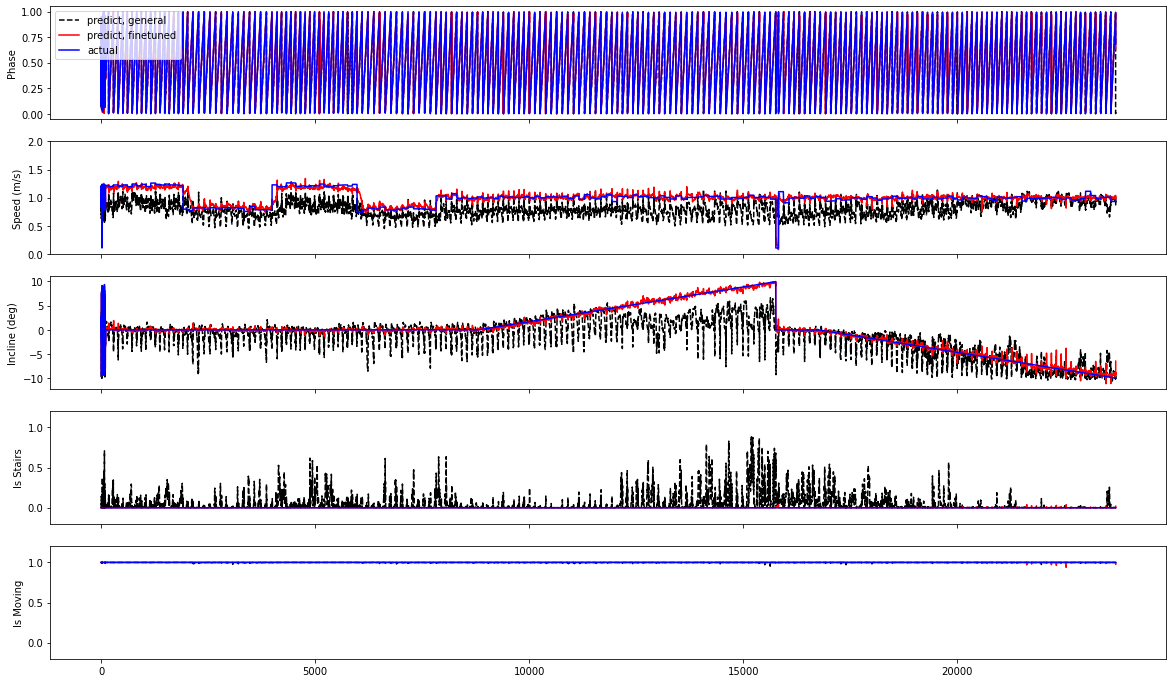

In [32]:
predictions_general = np.array(predictions_general)
predictions_finetuned = np.array(predictions_finetuned)
true_labels = np.array(true_labels)

#generate losses for general model
phase_losses_general = np.sqrt(phase_dist(predictions_general[:,0], true_labels[:,0])**2)
speed_losses_general = np.sqrt((predictions_general[:,1] - true_labels[:,1])**2)
incline_losses_general = np.sqrt((predictions_general[:,2] - true_labels[:,2])**2)
is_stairs_accuracy_general = np.sum(np.round(true_labels[:,3]) == np.round(predictions_general[:,3]))/len(true_labels[:,3])
is_moving_accuracy_general = np.sum(np.round(true_labels[:,4]) == np.round(predictions_general[:,4]))/len(true_labels[:,4])
print(predictions_general.shape)

#generate losses for finetuned model
phase_losses_finetuned = np.sqrt(phase_dist(predictions_finetuned[:,0], true_labels[:,0])**2)
speed_losses_finetuned = np.sqrt((predictions_finetuned[:,1] - true_labels[:,1])**2)
incline_losses_finetuned = np.sqrt((predictions_finetuned[:,2] - true_labels[:,2])**2)
is_stairs_accuracy_finetuned = np.sum(np.round(true_labels[:,3]) == np.round(predictions_finetuned[:,3]))/len(true_labels[:,3])
is_moving_accuracy_finetuned = np.sum(np.round(true_labels[:,4]) == np.round(predictions_finetuned[:,4]))/len(true_labels[:,4])
print(predictions_finetuned.shape)


print("="*30)
print('General Model')
print(f'Phase Losses: {np.mean(phase_losses_general):.3f} +- {np.std(phase_losses_general):.3f}')
print(f'Speed Losses: {np.mean(speed_losses_general):.3f} +- {np.std(speed_losses_general):.3f}')
print(f'Incline Losses: {np.mean(incline_losses_general):.3f} +- {np.std(incline_losses_general):.3f}')

print(f'Is Stairs Accuracy: {is_stairs_accuracy_general:.3f}')
print(f'Is Moving Accuracy: {is_moving_accuracy_general:.3f}')

print("="*30)
print('Finetuned Model')
print(f'Phase Losses: {np.mean(phase_losses_finetuned):.3f} +- {np.std(phase_losses_finetuned):.3f}')
print(f'Speed Losses: {np.mean(speed_losses_finetuned):.3f} +- {np.std(speed_losses_finetuned):.3f}')
print(f'Incline Losses: {np.mean(incline_losses_finetuned):.3f} +- {np.std(incline_losses_finetuned):.3f}')

print(f'Is Stairs Accuracy: {is_stairs_accuracy_finetuned:.3f}')
print(f'Is Moving Accuracy: {is_moving_accuracy_finetuned:.3f}')


fig, axs = plt.subplots(5,1,figsize=(20,12),sharex=True)
axs[0].plot(predictions_general[:,0],'k--',label='predict, general')
axs[0].plot(predictions_finetuned[:,0],'r',label='predict, finetuned')
axs[0].plot(true_labels[:,0],'b',label='actual')
axs[0].legend()
axs[0].set_ylabel('Phase')
# axs[0].set_xlim([80,5000])


axs[1].plot(predictions_general[:,1],'k--')
axs[1].plot(predictions_finetuned[:,1],'r')
axs[1].plot(true_labels[:,1],'b',label='actual')
axs[1].set_ylabel('Speed (m/s)')
axs[1].set_ylim([0,2])


axs[2].plot(predictions_general[:,2],'k--')
axs[2].plot(predictions_finetuned[:,2],'r')
axs[2].plot(true_labels[:,2],'b',label='actual')
axs[2].set_ylabel('Incline (deg)')
# axs[2].set_ylim([-15,15])

axs[3].plot(predictions_general[:,3],'k--')
axs[3].plot(predictions_finetuned[:,3],'r')
axs[3].plot(true_labels[:,3],'b',label='actual')
axs[3].set_ylabel('Is Stairs')
axs[3].set_ylim([-0.2,1.2])

axs[4].plot(predictions_general[:,4],'k--')
axs[4].plot(predictions_finetuned[:,4],'r')
axs[4].plot(true_labels[:,4],'b',label='actual')
axs[4].set_ylabel('Is Moving')
axs[4].set_ylim([-0.2,1.2])


In [ ]:
params = list(best_general_model.named_parameters())
print('The model has {:} different named parameters.\n'.format(len(params)))
for p in params:
    # print('p')
    # print(p[0])
    # print(p[1].data)
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# from prettytable import PrettyTable

# def count_parameters(model):
#     table = PrettyTable(["Modules", "Parameters"])
#     total_params = 0
#     for name, parameter in model.named_parameters():
#         if not parameter.requires_grad: continue
#         params = parameter.numel()
#         table.add_row([name, params])
#         total_params+=params
#     print(table)
#     print(f"Total Trainable Params: {total_params}")
#     return total_params
    
# count_parameters(best_general_model)


The model has 128 different named parameters.

embedding_layer.weight                                       (64, 7)
embedding_layer.bias                                           (64,)
decoder_embedding_layer.weight                               (64, 6)
decoder_embedding_layer.bias                                   (64,)
encoder.layers.0.self_attn.in_proj_weight                  (192, 64)
encoder.layers.0.self_attn.in_proj_bias                       (192,)
encoder.layers.0.self_attn.out_proj.weight                  (64, 64)
encoder.layers.0.self_attn.out_proj.bias                       (64,)
encoder.layers.0.linear1.weight                           (1024, 64)
encoder.layers.0.linear1.bias                                (1024,)
encoder.layers.0.linear2.weight                           (64, 1024)
encoder.layers.0.linear2.bias                                  (64,)
encoder.layers.0.norm1.weight                                  (64,)
encoder.layers.0.norm1.bias                             

Lowest Loss General: 0.10261752650763595
torch.Size([1, 100, 64])
torch.Size([192, 64])
torch.Size([1, 4, 100, 16])
torch.Size([1, 4, 100, 16])
torch.Size([1, 4, 100, 100])
4


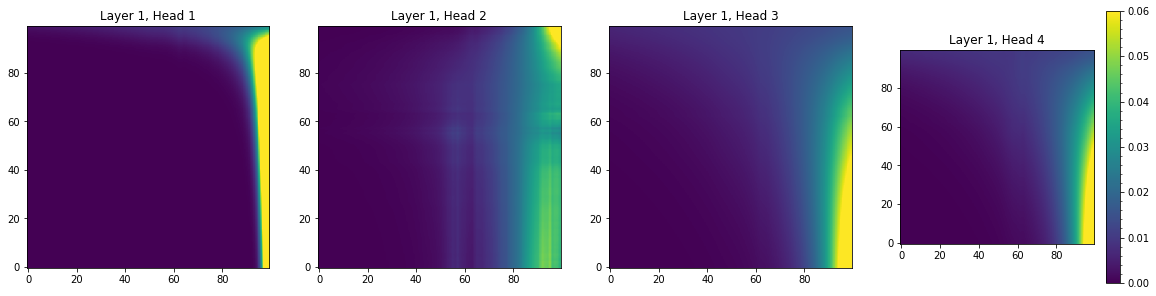

In [33]:
import torch.nn.functional as F
checkpoint = torch.load(general_model_dir+'ml_gait_estimator_dec_best_model.tar',map_location=torch.device(device))
# checkpoint = torch.load(finetuned_model_dir+'ml_gait_estimator_finetune_dec_best_model.tar',map_location=torch.device(device))

g = checkpoint['model_state_dict']
loss = checkpoint['loss']
print(f'Lowest Loss General: {loss}')
del g["positional_encoding_layer.pe"]

meas = test_dataset[10001]['meas'].detach().cpu()
# print(meas.shape)

embed_weight = g['embedding_layer.weight'].detach().cpu()
embed_bias = g['embedding_layer.bias'].detach().cpu()

embedding = torch.matmul(meas, torch.transpose(embed_weight,0,1))+embed_bias
embedding = torch.unsqueeze(embedding, dim=0)
print(embedding.shape)
device = torch.device("cpu")
# Create positional encoder
positional_encoding_layer = PositionalEncoder(
    d_model=64,
    dropout=0.0,
    max_seq_len=100
    )
    

dts = meas[:,DT_IDX]
dts = torch.unsqueeze(dts, dim=0)
dts = torch.unsqueeze(dts, dim=-1)
# print(dts.shape)
embedding = positional_encoding_layer(embedding, dts)


qkv_weights = g['encoder.layers.0.self_attn.in_proj_weight'].detach().cpu()
print(qkv_weights.shape)
qkv_bias = g['encoder.layers.0.self_attn.in_proj_bias'].detach().cpu()
batch_size = 1
seq_length = 100
num_heads = 4
head_dim = 64//num_heads

#method 1

w_q, w_k, w_v = qkv_weights.chunk(3)
b_q, b_k, b_v = qkv_bias.chunk(3)

q = F.linear(embedding, w_q, b_q)
k = F.linear(embedding, w_k, b_k)
v = F.linear(embedding, w_v, b_v)

q = q.contiguous().view(seq_length, batch_size * num_heads, head_dim).transpose(0, 1)
k = k.contiguous().view(seq_length, batch_size * num_heads, head_dim).transpose(0, 1)
v = v.contiguous().view(seq_length, batch_size * num_heads, head_dim).transpose(0, 1)

#add batch dimension
q = torch.unsqueeze(q, dim=0)
k = torch.unsqueeze(k, dim=0)
v = torch.unsqueeze(v, dim=0)

print(k.shape)
#method 2
# # Separate Q, K, V from linear output
# qkv = F.linear(embedding, qkv_weights, qkv_bias)
# qkv = qkv.reshape(batch_size, seq_length, num_heads, 3*head_dim)
# qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
# q, k, v = qkv.chunk(3, dim=-1)
# print(k.shape)

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention


values, attn = scaled_dot_product(q, k, v)

# qkv = torch.matmul(embedding, torch.transpose(embed_weight,0,1))

num_layers = 1

def get_attention_maps(x, model_dict, num_layers, batch_size, seq_length, num_heads, head_dim, mask=None):
    attention_maps = []
    for i in range(num_layers):

        qkv_weights = model_dict[f'encoder.layers.{i}.self_attn.in_proj_weight'].detach().cpu()
        qkv_bias = model_dict[f'encoder.layers.{i}.self_attn.in_proj_bias'].detach().cpu()
        w_q, w_k, w_v = qkv_weights.chunk(3)
        b_q, b_k, b_v = qkv_bias.chunk(3)

        q = F.linear(embedding, w_q, b_q)
        k = F.linear(embedding, w_k, b_k)
        v = F.linear(embedding, w_v, b_v)

        q = q.contiguous().view(seq_length, batch_size * num_heads, head_dim).transpose(0, 1)
        k = k.contiguous().view(seq_length, batch_size * num_heads, head_dim).transpose(0, 1)
        v = v.contiguous().view(seq_length, batch_size * num_heads, head_dim).transpose(0, 1)

        #add batch dimension
        q = torch.unsqueeze(q, dim=0)
        k = torch.unsqueeze(k, dim=0)
        v = torch.unsqueeze(v, dim=0)

        print(k.shape)

        values, attn = scaled_dot_product(q, k, v)
        attention_maps.append(attn)

        #gonna have to reimplement the ff part
        # x = l(x)
    return attention_maps

attentions = get_attention_maps(embedding, g, num_layers, batch_size, seq_length, num_heads, head_dim)
print(attentions[0].shape)


def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    print(num_heads)
    num_layers = len(attn_maps)
    seq_len = input_data.shape[1]
    fig_size = 6 if num_heads == 1 else 5
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            pos = ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0, vmax=0.06)
            # ax[row][column].set_xticks(list(range(seq_len)))
            # ax[row][column].set_xticklabels(input_data.tolist())
            # ax[row][column].set_yticks(list(range(seq_len)))
            # ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    # fig.subplots_adjust(hspace=0.5)
    # plt.show()

    cbar = fig.colorbar(pos)
    cbar.minorticks_on()

plot_attention_maps(embedding, attentions, idx=0)


# fig, ax = plt.subplots()
# im = ax.imshow(attentions[0][0][2].detach().cpu().numpy())




In [ ]:
tokens = [str(i) for i in range(seq_length)]
head_view(attention=attentions, tokens=tokens)

In [ ]:


# model_view(
#     encoder_attention=outputs.encoder_attentions,
#     decoder_attention=outputs.decoder_attentions,
#     cross_attention=outputs.cross_attentions,
#     encoder_tokens= encoder_text,
#     decoder_tokens = decoder_text
# )
tokens = [str(i) for i in range(seq_length)]
model_view(attention=attentions, tokens=tokens)

In [34]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

# device = torch.device("cpu")

# Model parameters
dim_val = 64 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 8 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_encoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
n_decoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
input_size = 7 # The number of input variables. 1 if univariate forecasting.
enc_seq_len = 100 # length of input given to encoder. Can have any integer value.
dec_seq_len = 1 # length of input given to decoder. Can have any integer value.

dropout_encoder = 0.1
dropout_decoder = 0.1
dropout_pos_enc = 0.0
dropout_regression = 0.1 
dim_feedforward_encoder = 1024
dim_feedforward_decoder = 1024

num_predicted_features = 6 # The number of output variables. 

#INITIALIZE BEST GENERAL MODEL
best_general_model = GaitTransformer(
    dim_val=dim_val,
    input_size=input_size, 
    n_encoder_layers=n_encoder_layers,
    n_decoder_layers=n_decoder_layers,
    n_heads=n_heads,
    enc_seq_len=enc_seq_len,
    dropout_encoder=dropout_encoder,
    dropout_decoder=dropout_decoder,
    dropout_pos_enc=dropout_pos_enc,
    dropout_regression=dropout_regression,
    num_predicted_features=num_predicted_features,
    dim_feedforward_encoder=dim_feedforward_encoder,
    dim_feedforward_decoder=dim_feedforward_decoder,
)

best_general_model.to(device)

checkpoint = torch.load(general_model_dir+'ml_gait_estimator_dec_best_model.tar',map_location=torch.device(device))
# checkpoint = torch.load(finetuned_model_dir+'ml_gait_estimator_finetune_dec_best_model.tar',map_location=torch.device(device))

g = checkpoint['model_state_dict']
loss = checkpoint['loss']
print(f'Lowest Loss General: {loss}')
del g["positional_encoding_layer.pe"]
best_general_model.load_state_dict(g)

START_IDX = 8000
N_STEPS = 600
MEAS_IDX = 6

SPEED_IDX = 2
INCLINE_IDX = 3
IS_STAIRS_IDX = 4
IS_MOVING_IDX = 5

saliency_foot_angle_phase = np.zeros((100, N_STEPS))
saliency_foot_angle_speed = np.zeros((100, N_STEPS))
saliency_foot_angle_incline = np.zeros((100, N_STEPS))
saliency_foot_angle_is_stairs = np.zeros((100, N_STEPS))
saliency_foot_angle_is_moving = np.zeros((100, N_STEPS))

predictions_general = []

for i in range(N_STEPS):

  meas = test_dataset[START_IDX+i]['meas'].to(device)
  meas = torch.unsqueeze(meas, dim=0)

  # we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
  meas.requires_grad_()


  '''
  forward pass through the model to get the scores, note that VGG-19 model doesn't perform softmax at the end
  and we also don't need softmax, we need scores, so that's perfect for us.
  '''
  tgt = SOS_token.to(device)#.repeat(b_state.shape[0], 1, 1)
  dts = meas[:,:,DT_IDX]
  # dts = torch.unsqueeze(dts, dim=0)
  dts = torch.unsqueeze(dts, dim=-1)
  # print(dts.shape)
  # input()
  # print(meas.device)
  # print(tgt.device)
  # print(dts.device)
  # Forward pass, calculate logit predictions
  preds = best_general_model(meas,tgt, dts)


  #store predictions to sanity check
  outputs_general = preds.detach().to('cpu').numpy()
  # print(preds)
  outputs_general = np.squeeze(outputs_general, axis=1)
    
  #unscale
  outputs_general = unscale_gait_state(outputs_general, speed_scale, incline_scale)

  # Store predictions and true labels
  predictions_general.extend(outputs_general.tolist())


  #compute gradients
  #phase
  cp = preds[0,0,0].squeeze().detach().cpu().numpy()
  sp = preds[0,0,1].squeeze().detach().cpu().numpy()

  #compute gradient for cp
  preds[0,0,0].backward(retain_graph=True)
  gradient = meas.grad.data
  gradient_cp = gradient.squeeze().cpu().numpy()
  gradient_cp = gradient_cp[:,MEAS_IDX]

  #compute gradient for sp
  meas.grad.zero_()
  preds[0,0,1].backward(retain_graph=True)
  gradient = meas.grad.data
  gradient_sp = gradient.squeeze().cpu().numpy()
  gradient_sp = gradient_sp[:,MEAS_IDX]

  saliency = (1/np.pi) * ((cp/(np.power(cp,2) + np.power(sp,2)))*(gradient_sp) - (sp/(np.power(cp,2) + np.power(sp,2)))*(gradient_cp))
  saliency_foot_angle_phase[:,i] = np.abs(saliency)

  #speed
  '''
  backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
  score_max with respect to nodes in the computation graph
  '''
  # external_grad = torch.tensor([[[1., 1., 1., 1., 1., 1.]]])
  # preds.backward(gradient=external_grad)
  meas.grad.zero_()
  preds[0,0,SPEED_IDX].backward(retain_graph=True)
  '''
  Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
  R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
  across all colour channels.
  '''

  gradient = meas.grad.data
  # print(gradient.shape)
  # print(gradient)

  saliency = gradient.squeeze().abs().cpu().numpy()
  saliency_foot_angle_speed[:,i] = saliency[:,MEAS_IDX]


  #incline
  meas.grad.zero_()
  preds[0,0,INCLINE_IDX].backward(retain_graph=True)
  gradient = meas.grad.data
  saliency = gradient.squeeze().abs().cpu().numpy()
  saliency_foot_angle_incline[:,i] = saliency[:,MEAS_IDX]

  #is_stairs
  meas.grad.zero_()
  preds[0,0,IS_STAIRS_IDX].backward(retain_graph=True)
  gradient = meas.grad.data
  saliency = gradient.squeeze().abs().cpu().numpy()
  saliency_foot_angle_is_stairs[:,i] = saliency[:,MEAS_IDX]

  #is_moving
  meas.grad.zero_()
  preds[0,0,IS_MOVING_IDX].backward(retain_graph=True)
  gradient = meas.grad.data
  saliency = gradient.squeeze().abs().cpu().numpy()
  saliency_foot_angle_is_moving[:,i] = saliency[:,MEAS_IDX]
    



  



Using GPU.
Lowest Loss General: 0.10261752650763595


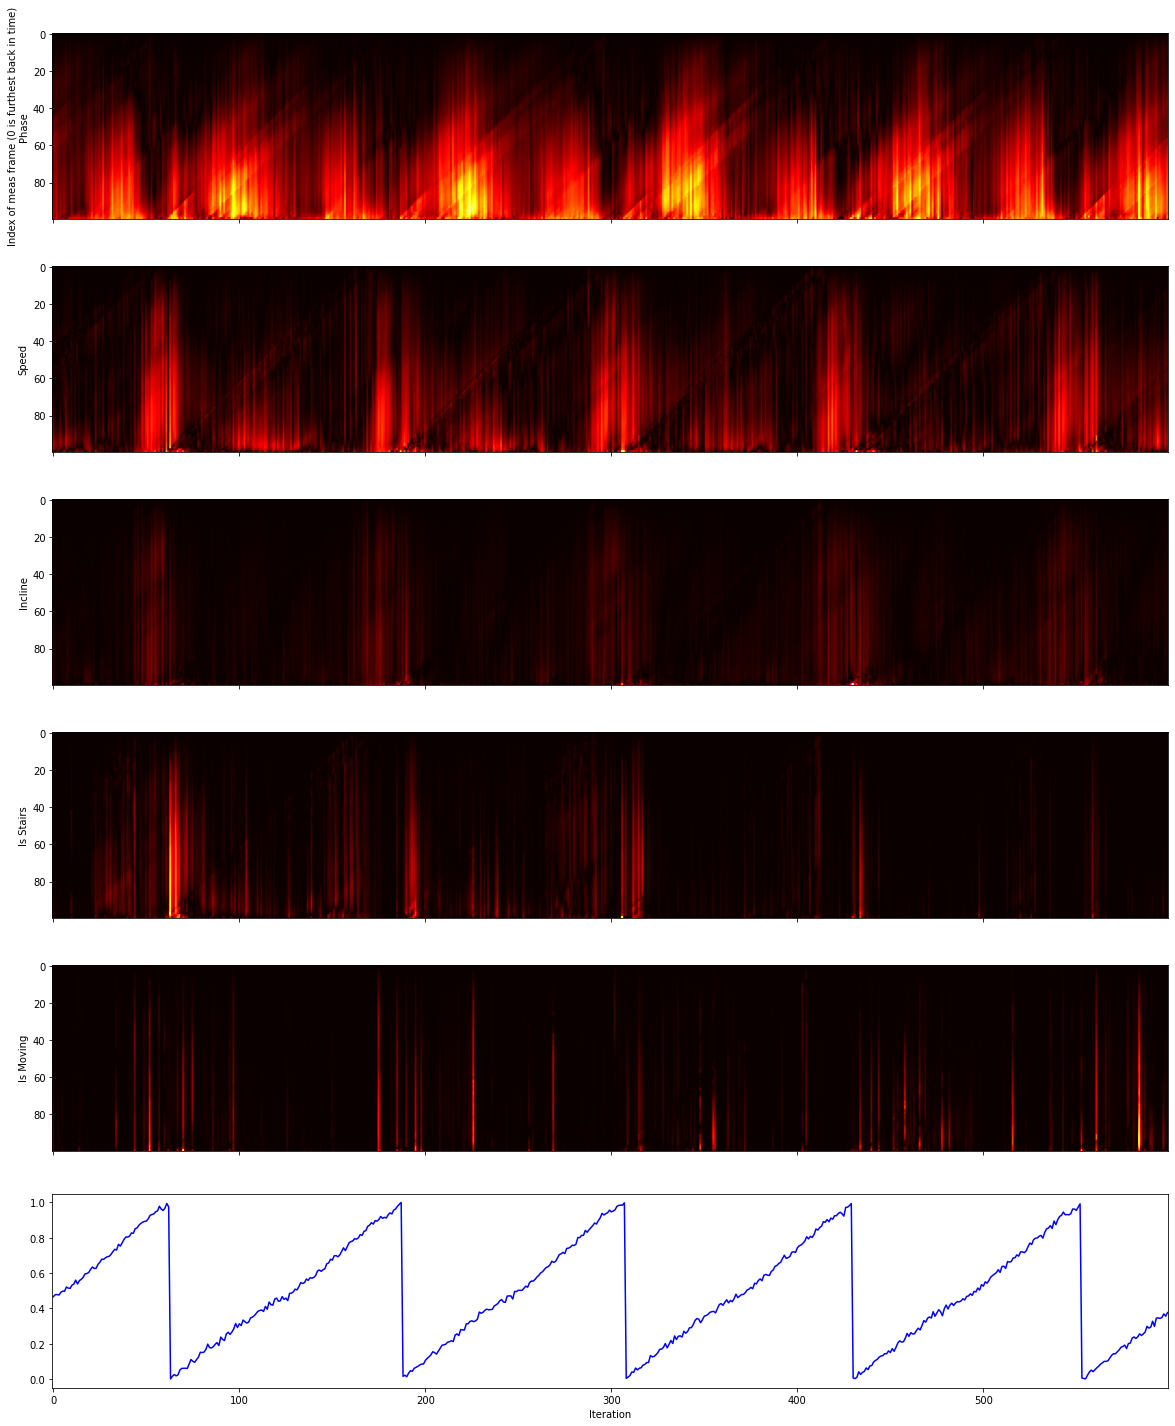

In [ ]:

predictions_general = np.array(predictions_general)
# code to plot the saliency map as a heatmap
fig, ax = plt.subplots(6,1,figsize=(20,25),sharex=True)

im = ax[0].imshow(saliency_foot_angle_phase, cmap=plt.cm.hot, origin='upper')
ax[0].set_ylabel('Index of meas frame (0 is furthest back in time)\nPhase')

im = ax[1].imshow(saliency_foot_angle_speed, cmap=plt.cm.hot, origin='upper')
# ax.set_yticks(list(range(0,100,10)))
ax[1].set_ylabel('Speed')
# ax[0].plot(predictions_general[:,0],'w',label='predict, general')

im = ax[2].imshow(saliency_foot_angle_incline, cmap=plt.cm.hot, origin='upper')
ax[2].set_ylabel('Incline')

im = ax[3].imshow(saliency_foot_angle_is_stairs, cmap=plt.cm.hot, origin='upper')
ax[3].set_ylabel('Is Stairs')

im = ax[4].imshow(saliency_foot_angle_is_moving, cmap=plt.cm.hot, origin='upper')
ax[4].set_ylabel('Is Moving')

#plot phase
ax[5].plot(predictions_general[:,0],'b',label='predict, general')
ax[5].set_xlabel('Iteration')

plt.show()


#sanity check predictions
DO_PLOT_SANITY_CHECK = not True
if DO_PLOT_SANITY_CHECK:


  fig, axs = plt.subplots(5,1,figsize=(20,20),sharex=True)
  axs[0].plot(predictions_general[:,0],'k--',label='predict, general')
  axs[0].legend()
  axs[0].set_ylabel('Phase')
  # axs[0].set_xlim([80,5000])


  axs[1].plot(predictions_general[:,1],'k--')
  axs[1].set_ylabel('Speed (m/s)')
  axs[1].set_ylim([0,2])


  axs[2].plot(predictions_general[:,2],'k--')
  axs[2].set_ylabel('Incline (deg)')
  # axs[2].set_ylim([-15,15])

  axs[3].plot(predictions_general[:,3],'k--')
  axs[3].set_ylabel('Is Stairs')
  axs[3].set_ylim([-0.2,1.2])

  axs[4].plot(predictions_general[:,4],'k--')
  axs[4].set_ylabel('Is Moving')
  axs[4].set_ylim([-0.2,1.2])